In [25]:
import numpy as np
import pandas as pd
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import preprocessing

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
%matplotlib inline
plt.style.use('ggplot')

from data_provider import get_data

In [27]:
dataset = get_data('data/original/results.csv')
dataset.tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,...,away_GK_Diving,away_GK_Handling,away_GK_Kicking,away_GK_Positioning,away_GK_Reflexes,away_goal_mean,away_goals_with_home,goal_diff_with_away,home_goal_mean,home_goals_with_away
39344,2018-06-04,Italy,Netherlands,1,1,Friendly,Turin,Italy,False,2018,...,79.0,80.0,75.5,80.0,80.0,1.914894,1.00,7.0,1.530612,1.35
39345,2018-06-04,Serbia,Chile,0,1,Friendly,Graz,Austria,True,2018,...,78.0,77.0,78.0,76.5,77.0,1.574074,1.00,2.0,1.361111,3.00
39346,2018-06-04,Slovakia,Morocco,1,2,Friendly,Geneva,Switzerland,True,2018,...,44.0,47.0,44.5,45.5,44.0,1.659574,2.00,-1.0,1.575000,1.00
39347,2018-06-04,Armenia,Moldova,0,0,Friendly,Kematen,Austria,True,2018,...,13.0,15.0,14.0,13.5,12.5,0.486486,1.75,-2.0,1.250000,1.25
39348,2018-06-04,India,Kenya,3,0,Friendly,Mumbai,India,False,2018,...,13.0,14.5,15.0,13.5,13.5,0.911111,0.00,0.0,1.870968,0.00


In [28]:
print("Dataset length", dataset.shape[0])
dataset = dataset.dropna()
print("Dataset complete cases length", dataset.shape[0])

Dataset length 39349
Dataset complete cases length 6575


In [29]:
dataset.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'year', 'home_elo',
       'away_elo', 'home_overall_rating_max', 'home_overall_rating_min',
       'home_overall_rating_avg', 'home_potential_max', 'home_potential_min',
       'home_potential_avg', 'home_height', 'home_weight', 'home_age',
       'home_top_11_age', 'home_weak_foot', 'home_international_reputation',
       'home_Crossing', 'home_Finishing', 'home_Heading_Accuracy',
       'home_Short_Passing', 'home_Dribbling', 'home_FK_Accuracy',
       'home_Long_Passing', 'home_Ball_Control', 'home_Acceleration',
       'home_Sprint_Speed', 'home_Reactions', 'home_Shot_Power',
       'home_Stamina', 'home_Strength', 'home_Long_Shots', 'home_Aggression',
       'home_Penalties', 'home_Marking', 'home_Standing_Tackle',
       'home_GK_Diving', 'home_GK_Handling', 'home_GK_Kicking',
       'home_GK_Positioning', 'home_GK_Reflexes', 'away_overall_rating_max',
       '

In [30]:
def calculate_relative_features(dataset):
    dataset["home_win"] = np.sign(dataset["home_score"] - dataset["away_score"])
    dataset["elo_diff"] = dataset["home_elo"] - dataset["away_elo"]
    dataset["rating_diff"] = dataset["home_overall_rating_avg"] - dataset["away_overall_rating_avg"]
    dataset["potential_diff"] = dataset["home_potential_avg"] - dataset["away_potential_avg"]
    dataset["height_diff"] = dataset["home_height"] - dataset["away_height"]
    dataset["weight_diff"] = dataset["home_weight"] - dataset["away_weight"]
    dataset["age_diff"] = dataset["home_age"] - dataset["away_age"]
    dataset["weak_foot_diff"] = dataset["home_weak_foot"] - dataset["away_weak_foot"]
    dataset["internationl_repuatiotion_diff"] = dataset["home_international_reputation"] - dataset["away_international_reputation"]
    dataset["crossing_diff"] = dataset["home_Crossing"] - dataset["away_Crossing"]
    dataset["finishing_diff"] = dataset["home_Finishing"] - dataset["away_Finishing"]
    dataset["heading_accuracy_diff"] = dataset["home_Heading_Accuracy"] - dataset["away_Heading_Accuracy"]
    dataset["short_passing_diff"] = dataset["home_Short_Passing"] - dataset["away_Short_Passing"]
    dataset["dribbling_diff"] = dataset["home_Dribbling"] - dataset["away_Dribbling"]
    dataset["fk_accuracy_diff"] = dataset["home_FK_Accuracy"] - dataset["away_FK_Accuracy"]
    dataset["long_passing_diff"] = dataset["home_Long_Passing"] - dataset["away_Long_Passing"]
    dataset["ball_control_diff"] = dataset["home_Ball_Control"] - dataset["away_Ball_Control"]
    dataset["acceleration_diff"] = dataset["home_Acceleration"] - dataset["away_Acceleration"]
    dataset["sprint_speed_diff"] = dataset["home_Sprint_Speed"] - dataset["away_Sprint_Speed"]
    dataset["reactions_diff"] = dataset["home_Reactions"] - dataset["away_Reactions"]
    dataset["shot_power_diff"] = dataset["home_Shot_Power"] - dataset["away_Shot_Power"]
    dataset["stamina_diff"] = dataset["home_Stamina"] - dataset["away_Stamina"]
    dataset["strength_diff"] = dataset["home_Strength"] - dataset["away_Strength"]
    dataset["long_shots_diff"] = dataset["home_Long_Shots"] - dataset["away_Long_Shots"]
    dataset["aggression_diff"] = dataset["home_Aggression"] - dataset["away_Aggression"]
    dataset["penalties_diff"] = dataset["home_Penalties"] - dataset["away_Penalties"]
    dataset["marking_diff"] = dataset["home_Marking"] - dataset["away_Marking"]
    dataset["standing_tackle_diff"] = dataset["home_Standing_Tackle"] - dataset["away_Standing_Tackle"]
    dataset["gk_diving_diff"] = dataset["home_GK_Diving"] - dataset["away_GK_Diving"]
    dataset["gk_handling_diff"] = dataset["home_GK_Handling"] - dataset["away_GK_Handling"]
    dataset["gk_kicking_diff"] = dataset["home_GK_Kicking"] - dataset["away_GK_Kicking"]
    dataset["gk_reflexes_diff"] = dataset["home_GK_Reflexes"] - dataset["away_GK_Reflexes"]
    return dataset

dataset = calculate_relative_features(dataset)

In [31]:
feature_columns = ["elo_diff", "rating_diff", "potential_diff",
                   "height_diff", "weight_diff", "age_diff", "weak_foot_diff",
                   "internationl_repuatiotion_diff", "crossing_diff", "finishing_diff", "heading_accuracy_diff",
                   "short_passing_diff", "dribbling_diff", "fk_accuracy_diff", "long_passing_diff",
                   'ball_control_diff', 'acceleration_diff', 'sprint_speed_diff', "reactions_diff",
                   'shot_power_diff', 'stamina_diff', 'strength_diff', 'long_shots_diff',
                   "aggression_diff", "penalties_diff", "marking_diff", "standing_tackle_diff",
                   "away_goal_mean", "away_goals_with_home", "goal_diff_with_away", "home_goal_mean",
                   "home_goals_with_away", "gk_diving_diff", "gk_handling_diff", "gk_kicking_diff", "gk_reflexes_diff"]

wtl_col = "home_win"

In [32]:
no_friendly_or_wc = dataset[(dataset["tournament"] != "Friendly") & (dataset["tournament"] != "FIFA World Cup")]
print("No friendly or WC games length: ", no_friendly_or_wc.shape[0])

X = no_friendly_or_wc[feature_columns]
y = no_friendly_or_wc[wtl_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("No friendly games train set length: ", X_train.shape[0])

friendly_games = dataset[dataset["tournament"] == "Friendly"]
print("Friendly games length: ", friendly_games.shape[0])
X_friendly = friendly_games[feature_columns]
y_friendly = friendly_games[wtl_col]

X_train = pd.concat([X_train, X_friendly])
y_train = pd.concat([y_train, y_friendly])

wc_games = dataset[dataset["tournament"] == "FIFA World Cup"]
print("WC games length: ", wc_games.shape[0])
X_wc = wc_games[feature_columns]
y_wc = wc_games[wtl_col]
X_test = pd.concat([X_test, X_wc])
y_test = pd.concat([y_test, y_wc])

print("Whole train set length: ", X_train.shape[0])
print("Whole test set length: ", X_test.shape[0])
print("Train set width: ", X_train.shape[1])

No friendly or WC games length:  3734
No friendly games train set length:  2800
Friendly games length:  2716
WC games length:  125
Whole train set length:  5516
Whole test set length:  1059
Train set width:  36


In [33]:
no_friendly_or_wc

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,...,strength_diff,long_shots_diff,aggression_diff,penalties_diff,marking_diff,standing_tackle_diff,gk_diving_diff,gk_handling_diff,gk_kicking_diff,gk_reflexes_diff
28854,2007-01-07,Haiti,Bermuda,2,0,CFU Caribbean Cup qualification,Couva,Trinidad and Tobago,True,2007,...,11.475000,2.700000,16.650,19.066667,25.200000,11.350000,-0.5,8.5,31.5,7.5
28858,2007-01-09,Bermuda,Haiti,0,3,CFU Caribbean Cup qualification,Couva,Trinidad and Tobago,True,2007,...,-11.475000,-2.700000,-16.650,-19.066667,-25.200000,-11.350000,0.5,-8.5,-31.5,-7.5
28864,2007-01-12,Trinidad and Tobago,Barbados,1,1,CFU Caribbean Cup,Port of Spain,Trinidad and Tobago,False,2007,...,10.000000,2.800000,17.800,14.333333,44.166667,38.400000,53.5,52.0,29.5,57.0
28873,2007-01-15,Haiti,Barbados,2,0,CFU Caribbean Cup,Port of Spain,Trinidad and Tobago,True,2007,...,-0.225000,-5.400000,3.150,4.666667,22.500000,10.450000,-4.5,2.5,21.5,0.5
28883,2007-01-17,Trinidad and Tobago,Haiti,3,1,CFU Caribbean Cup,Port of Spain,Trinidad and Tobago,False,2007,...,10.225000,8.200000,14.650,9.666667,21.666667,27.950000,58.0,49.5,8.0,56.5
28901,2007-01-23,Trinidad and Tobago,Haiti,1,2,CFU Caribbean Cup,Port of Spain,Trinidad and Tobago,False,2007,...,10.225000,8.200000,14.650,9.666667,21.666667,27.950000,58.0,49.5,8.0,56.5
28919,2007-02-06,Cyprus,Hungary,2,1,Cyprus International Tournament,Limassol,Cyprus,False,2007,...,-11.620000,-5.300000,-5.200,2.000000,-6.000000,-16.000000,-65.0,-62.5,-12.5,-67.5
28922,2007-02-06,Latvia,Bulgaria,0,2,Cyprus International Tournament,Larnaca,Cyprus,True,2007,...,-30.300000,-14.200000,-25.900,-15.000000,-33.166667,-59.900000,-64.5,-60.5,-29.0,-75.0
28934,2007-02-07,Cyprus,Bulgaria,0,3,Cyprus International Tournament,Nicosia,Cyprus,False,2007,...,-13.920000,-16.000000,-14.200,-4.666667,-6.666667,-19.200000,-62.0,-61.0,-18.0,-73.0
28942,2007-02-07,Latvia,Hungary,0,2,Cyprus International Tournament,Limassol,Cyprus,True,2007,...,-28.000000,-3.500000,-16.900,-8.333333,-32.500000,-56.700000,-67.5,-62.0,-23.5,-69.5


<Figure size 1440x432 with 0 Axes>

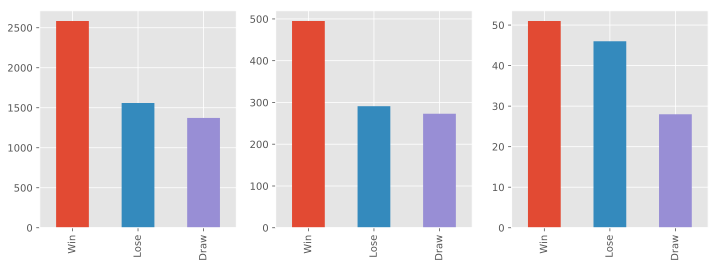

In [34]:
def get_labeled_df(s):
    df = pd.DataFrame(s)
    df[df["home_win"] == 1] = "Win"
    df[df["home_win"] == 0] = "Draw"
    df[df["home_win"] == -1] = "Lose"
    return df

plt.figure(figsize=(20, 6))
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
pd.value_counts(get_labeled_df(y_train)["home_win"]).plot.bar(ax=axes[0])
pd.value_counts(get_labeled_df(y_test)["home_win"]).plot.bar(ax=axes[1])
pd.value_counts(get_labeled_df(y_wc)["home_win"]).plot.bar(ax=axes[2])

,elo_diff,rating_diff,potential_diff,height_diff,weight_diff,age_diff,weak_foot_diff,internationl_repuatiotion_diff,crossing_diff,finishing_diff,...,standing_tackle_diff,away_goal_mean,away_goals_with_home,goal_diff_with_away,home_goal_mean,home_goals_with_away,gk_diving_diff,gk_handling_diff,gk_kicking_diff,gk_reflexes_diff
elo_diff,1.000000,0.772635,0.766213,0.533219,0.432760,0.444409,0.460481,0.712595,0.697351,0.680591,...,0.597480,-0.490994,-0.464701,0.376623,0.503054,0.486505,0.474128,0.468555,0.481579,0.470221
rating_diff,0.772635,1.000000,0.972454,0.744876,0.627976,0.665384,0.561208,0.767726,0.761795,0.758084,...,0.717091,-0.381404,-0.417610,0.348732,0.398992,0.444842,0.537735,0.533755,0.529477,0.536779
potential_diff,0.766213,0.972454,1.000000,0.755860,0.620302,0.563745,0.557089,0.753068,0.760889,0.753070,...,0.716850,-0.368574,-0.412281,0.349526,0.396869,0.451009,0.542474,0.537597,0.529761,0.540970
height_diff,0.533219,0.744876,0.755860,1.000000,0.894146,0.664211,0.494961,0.472199,0.610241,0.632621,...,0.662500,-0.246231,-0.311894,0.218657,0.267893,0.324902,0.590369,0.581853,0.550202,0.585719
weight_diff,0.432760,0.627976,0.620302,0.894146,1.000000,0.602364,0.366719,0.394450,0.448657,0.513133,...,0.563256,-0.206444,-0.255209,0.165932,0.214735,0.254047,0.511092,0.502917,0.463877,0.502985
age_diff,0.444409,0.665384,0.563745,0.664211,0.602364,1.000000,0.434306,0.452690,0.541830,0.528247,...,0.565793,-0.233683,-0.262533,0.178141,0.193431,0.237719,0.468591,0.462135,0.449554,0.466868
weak_foot_diff,0.460481,0.561208,0.557089,0.494961,0.366719,0.434306,1.000000,0.400803,0.562451,0.547434,...,0.463422,-0.269797,-0.258507,0.185217,0.273072,0.255577,0.277038,0.270622,0.288681,0.274521
internationl_repuatiotion_diff,0.712595,0.767726,0.753068,0.472199,0.394450,0.452690,0.400803,1.000000,0.581573,0.574675,...,0.541085,-0.367128,-0.380063,0.377561,0.412901,0.410660,0.431657,0.425586,0.402292,0.426593
crossing_diff,0.697351,0.761795,0.760889,0.610241,0.448657,0.541830,0.562451,0.581573,1.000000,0.873605,...,0.785098,-0.335781,-0.373946,0.298921,0.353779,0.427227,0.462774,0.455484,0.498937,0.464685
finishing_diff,0.680591,0.758084,0.753070,0.632621,0.513133,0.528247,0.547434,0.574675,0.873605,1.000000,...,0.657337,-0.329157,-0.373914,0.286800,0.344069,0.414357,0.450732,0.443961,0.471403,0.453008


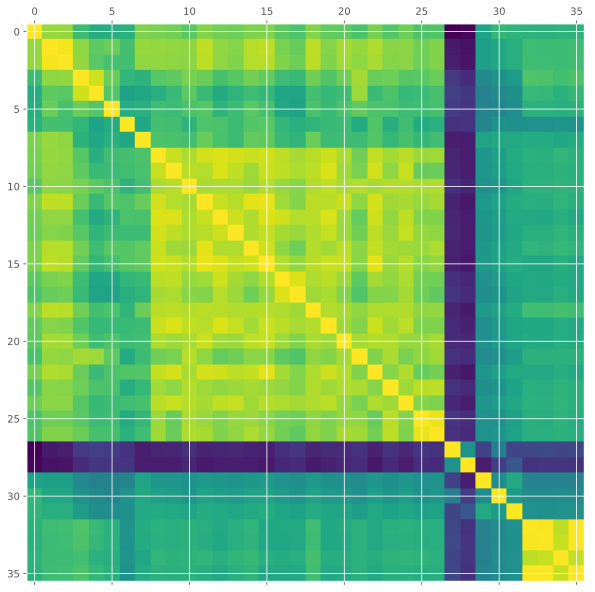

In [35]:
plt.figure(figsize=(10,10))
plt.matshow(X_train.corr(), fignum=1)
X_train.corr()

In [11]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [12]:
def get_feature_importance(clf):
    zipped = sorted(zip(feature_columns, clf.feature_importances_), key = lambda t: t[1], reverse=True)
    for feature, importance in zipped:
        print(f"{feature}: {importance}")

In [13]:
def run_random_search(clf, param_dist, 
                      Xtrain, ytrain, 
                      Xtest, ytest, 
                      X_wc, y_wc,
                      n_iter_search=60, custom_report_for_model=None, 
                      preprocess=False):
    
    if preprocess:
        scaler = preprocessing.StandardScaler().fit(Xtrain)
        Xtrain = scaler.transform(Xtrain)
        Xtest = scaler.transform(Xtest)
    random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search)
    start = time()
    random_search.fit(Xtrain, ytrain)
    print("TRAIN SET METRICS:")
    print("SCORE: ", random_search.score(Xtrain, ytrain))
    y_true, y_pred = ytrain, random_search.predict(Xtrain)
    print(classification_report(y_true, y_pred))
    print("BEST PARAMS: ", random_search.best_params_)
    print()
    print()
    
    best_clf = random_search.best_estimator_
    best_clf.fit(Xtrain, ytrain)
    
    print("TEST SET METRICS:")
    print("SCORE: ", best_clf.score(Xtest, ytest))
    y_true, y_pred = ytest, best_clf.predict(Xtest)
    print("\n",classification_report(y_true, y_pred))
        
    print()
    print()
    print("WC SET METRICS:")
    print("SCORE: ", random_search.score(X_wc, y_wc))
    y_true, y_pred = y_wc, best_clf.predict(X_wc)
    print("\n",classification_report(y_true, y_pred))
    
    print()
    print()
    if custom_report_for_model:
        custom_report_for_model(best_clf)
    return best_clf

In [36]:
clf = RandomForestClassifier(oob_score=True, bootstrap=True, n_jobs=-1)

param_dist = {"n_estimators": [1000],
              "max_depth": [None],
              "min_samples_leaf": [5],
              "max_features": ["sqrt"],
              "criterion": ["gini"]}
best_clf = run_random_search(clf, param_dist,
                             X_train, y_train, 
                             X_test, y_test, 
                             X_wc, y_wc,
                             custom_report_for_model=get_feature_importance, 
                             preprocess=False, n_iter_search=1)

TRAIN SET METRICS:
SCORE:  0.914430746918
             precision    recall  f1-score   support

         -1       0.92      0.90      0.91      1559
          0       0.99      0.82      0.90      1373
          1       0.88      0.97      0.92      2584

avg / total       0.92      0.91      0.91      5516

BEST PARAMS:  {'n_estimators': 1000, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini'}


TEST SET METRICS:
SCORE:  0.631728045326

              precision    recall  f1-score   support

         -1       0.59      0.75      0.66       291
          0       0.43      0.09      0.15       273
          1       0.67      0.86      0.76       495

avg / total       0.59      0.63      0.57      1059



WC SET METRICS:
SCORE:  0.712

              precision    recall  f1-score   support

         -1       0.82      0.80      0.81        46
          0       0.43      0.11      0.17        28
          1       0.67      0.96      0.79        51

avg /

In [26]:
wc_2018 = get_data('data/original/fifa_match_results_2018-6-01-2018-8-01.csv')
wc_2018 = calculate_relative_features(wc_2018)
print(wc_2018)

    Unnamed: 0  away_score       away_team       date  home_score  \
0            0           0    Saudi Arabia 2018-06-14           5   
1            1           1         Uruguay 2018-06-15           0   
2            2           1         IR Iran 2018-06-15           0   
3            3           3           Spain 2018-06-15           3   
4            4           1       Australia 2018-06-16           2   
5            5           1         Iceland 2018-06-16           1   
6            6           1         Denmark 2018-06-16           0   
7            7           0         Nigeria 2018-06-16           2   
8            8           1          Serbia 2018-06-17           0   
9            9           1          Mexico 2018-06-17           0   
10          10           1     Switzerland 2018-06-17           1   
11          11           0  Korea Republic 2018-06-18           1   
12          12           0          Panama 2018-06-18           3   
13          13           2        